In [9]:
import sys
import numba
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
import vector
vector.register_numba()
vector.register_awkward()
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import random
import itertools
import seaborn as sns
#sns.set()
import torch
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics.classification import BinaryROC
from pprint import pprint 
import csv
hep.style.use(hep.style.ROOT)
import tensorflow as tf
from importlib import reload
plt=reload(plt)
import hist
import numba
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from ignite.contrib.metrics import ROC_AUC
from ignite.engine import *
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
import matplotlib.backends.backend_pdf

/work/dvalsecc/miniconda3/envs/coffea4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'torchmetrics'

In [2]:
torch.cuda.is_available()

NameError: name 'torch' is not defined

In [3]:
numba.__version__

'0.51.2'

In [4]:
!pwd

/eos/home-i01/k/kshamana/tthbb/PocketCoffea/notebooks/JetTagging


# Loading the jets combinations dataset

In [10]:
df = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbb_analysis/dataset/jets_combinations_ttHbb_fullymatched_v1.parquet")

In [94]:
(jets_fullymatched,  # initial collections of jets, already fully matched
comb_index,          # indices of jets with all the combinations for all the events
signal_comb,         # mask to get the "signal" combination  [events, True/False]
jets_combinations,   # collections of jets, many different collections for each event (from comb_index)
higgs_jets,          # higgs_jets (index 0, 1 of the combination)
tlep_jets,           # tlep jet (index 2 of the combination)
thad_jets,           # thad jets (index 3,4,5 of the combination)
whad_jets            # whad_jets (index 4 5 of the combination)
) = ak.unzip(df)

jets_combinations = ak.with_name(jets_combinations, name="Momentum4D")
higgs_jets = ak.with_name(higgs_jets, name="Momentum4D")
tlep_jets = ak.with_name(tlep_jets, name="Momentum4D")
thad_jets = ak.with_name(thad_jets, name="Momentum4D")
whad_jets = ak.with_name(whad_jets, name="Momentum4D")

Getting only the "signal", the true, combination

In [51]:
jets_signal = ak.flatten(jets_combinations[signal_comb], axis=1)

Getting the jets combinations to plot for the signal.
N.B it is needed to reorder them by pt

In [75]:
jets_2h = jets_signal[jets_signal.prov==1]
jets_2h = jets_2h[ak.argsort(jets_2h.pt,ascending=False)]
jets_3ht = jets_signal[jets_signal.prov==2]
jets_3ht = jets_3ht[ak.argsort(jets_3ht.pt, ascending=False)]
jets_1lt = jets_signal[jets_signal.prov==3]

## Kinematic studies

1. Histogram of the invariant mass of the Higgs boson from the two tagged jets
2. Histogram of the mass of the hadronic top from the three tagged jets
3. Histogram of the pt of the leading and subleading jets matched to the higgs

## The invariant mass of the Higgs matched with 2 jets

In [76]:
Higgs_mass=(jets_2h[:,0]+jets_2h[:,1]).mass
Higgs_mass

<Array [137, 104, 141, ... 93.9, 167, 118] type='53455 * float64'>

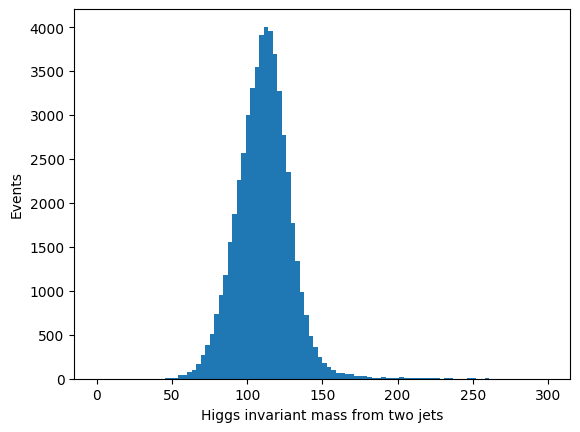

In [77]:
plt.hist(Higgs_mass, bins=100, range=(0,300))
#plt.yscale("log")
plt.xlabel('Higgs invariant mass from two jets')
plt.ylabel('Events')
plt.show()

## The mass of the hadronic top matched with 3 jets

In [78]:
ht_mass =  (jets_3ht[:,0]+jets_3ht[:,1]+jets_3ht[:,2]).mass
ht_mass

<Array [171, 164, 159, 168, ... 193, 162, 161] type='53455 * float64'>

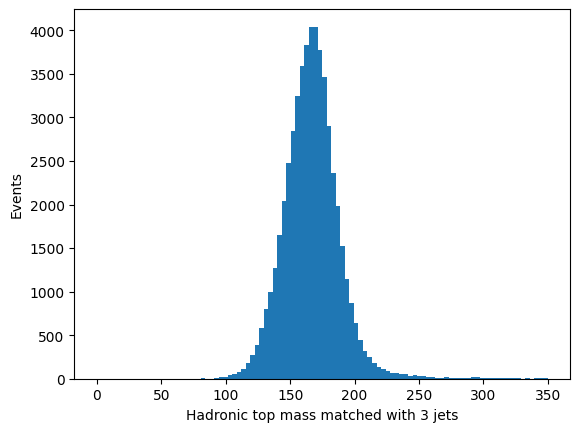

In [79]:
plt.hist(ht_mass, bins=100, range=(0,350))
#plt.yscale("log")
plt.xlabel('Hadronic top mass matched with 3 jets')
plt.ylabel('Events')
plt.show()

## Pt of the leading and subleading jets matched to the Higgs 

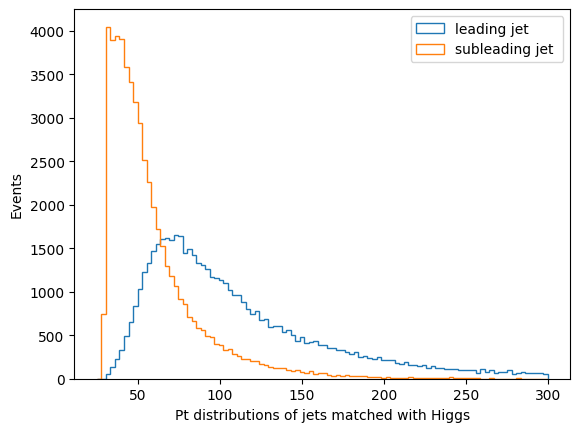

In [80]:
plt.hist(jets_2h[:,0].pt, bins=100, range=(25,300), histtype="step", label="leading jet")
plt.hist(jets_2h[:,1].pt, bins=100, range=(25,300), histtype="step", label= "subleading jet ")
#plt.yscale("log")
plt.legend()
plt.xlabel('Pt distributions of jets matched with Higgs')
plt.ylabel('Events')
plt.show()

1. Plot a 2D distribution of the pts jets of the Higgs
2. Plot the eta distribution of the higgs and top quarks
3. Plot the 2D distribution comparing the leading higgs jets and leading top jets

## Eta distribution of the higgs and top quarks

In [81]:
th_eta = (jets_3ht[:,0]+jets_3ht[:,1]+jets_3ht[:,2]).eta
Higgs_eta = (jets_2h[:,0]+jets_2h[:,1]).eta
len(Higgs_eta), len(th_eta)

(53455, 53455)

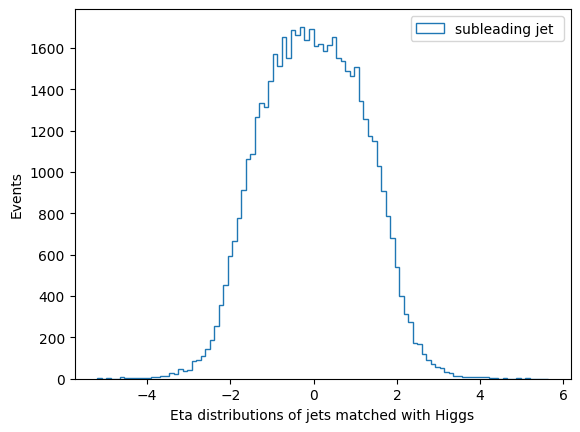

In [82]:
#plt.hist(Higgs_pt,bins=100, label="leading jet")
plt.hist(th_eta, bins=100, histtype="step", label= "subleading jet ")
#plt.yscale("log")
plt.legend()
plt.xlabel('Eta distributions of jets matched with Higgs')
plt.ylabel('Events')
plt.show()

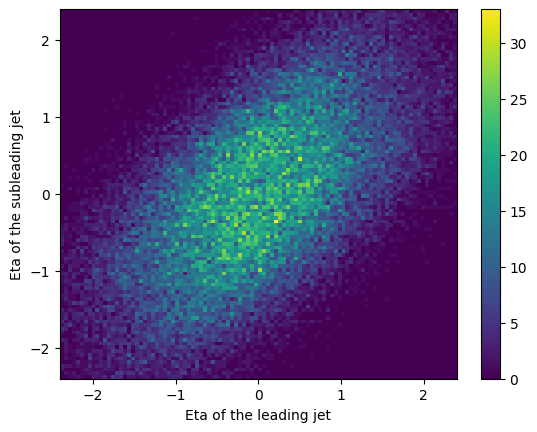

In [83]:
plt.hist2d(jets_2h[:,0].eta, jets_2h[:,1].eta, bins=100, range=np.array([[-2.4,2.4],[-2.4,2.4]]))
plt.xlabel('Eta of the leading jet')
plt.ylabel('Eta of the subleading jet')
plt.colorbar()
plt.show()

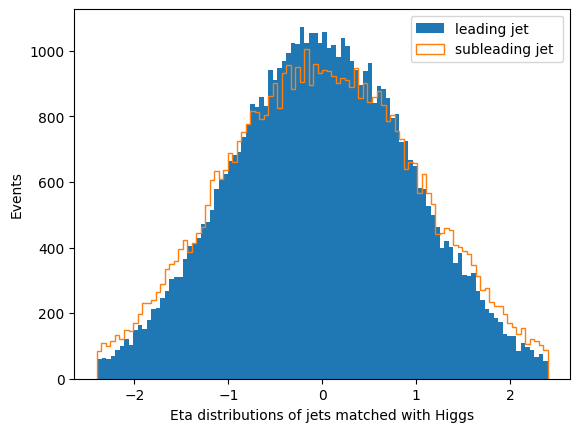

In [84]:
plt.hist(jets_2h[:,0].eta,bins=100, label="leading jet")
plt.hist(jets_2h[:,1].eta, bins=100,  histtype="step", label= "subleading jet ")
#plt.yscale("log")
plt.legend()
plt.xlabel('Eta distributions of jets matched with Higgs')
plt.ylabel('Events')
plt.show()

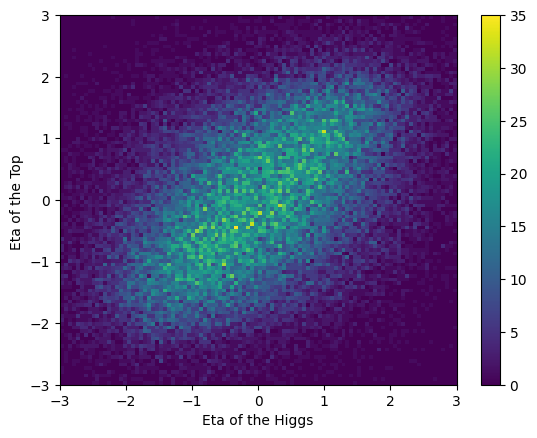

In [85]:
plt.hist2d(Higgs_eta, th_eta, bins=100, range=np.array([[-3,3],[-3,3]]))
plt.xlabel('Eta of the Higgs')
plt.ylabel('Eta of the Top ')
plt.colorbar()
plt.show()

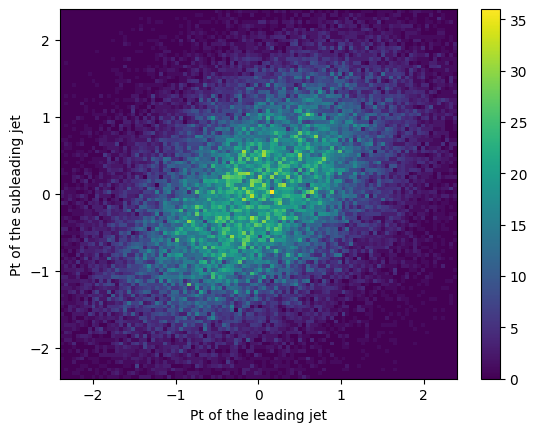

In [86]:
leadingHj_eta = jets_2h[:,0].eta
leadingtj_eta = jets_3ht[:,0].eta
plt.hist2d(leadingHj_eta, leadingtj_eta, bins=100, range=np.array([[-2.4,2.4],[-2.4,2.4]]))
plt.xlabel('Pt of the leading jet')
plt.ylabel('Pt of the subleading jet')
plt.colorbar()
plt.show()

1. Get the efficiency (n events passing the requirement/total number of events), of the events having the higgs jets matched, having the higgs jets and hadronic top ones matched, having the higgs matched, the hadronic top and the leptonic top matched, and then also having the additional radiation matched

2. Select only the events with the higgs jets, leptonic and hadronic top matched
3. Plot the deltaEta between the higgs vector and the hadronic top vector

# Extracting kinematic variables and building the training dataset

In [98]:
def get_variables(jets_higgs, jets_ht, jets_lt):
    hig = jets_higgs[:,0] + jets_higgs[:,1]
    htop = jets_ht[:,0] + jets_ht[:,1] + jets_ht[:,2] 
    ltop = jets_lt[:,0] 
    variables = {
    "deltaEta_H_htop" : np.abs(hig.eta - htop.eta),
    "deltaEta_htop_ltop" : np.abs(htop.eta - ltop.eta),
    "deltaPhi_H_htop" : hig.deltaphi(htop),
    "deltaPhi_H_ltop" : hig.deltaphi(ltop),
    "deltaPhi_htop_ltop" : htop.deltaphi(ltop),
    "Eta_H" : hig.eta,
    "Phi_H" : hig.phi,
    "Pt_H" : hig.pt,
    "Phi_htop" : htop.phi,
    "Pt_htop" : htop.pt,
    "Phi_ltop" : ltop.phi,
    "Pt_ltop" : ltop.pt,
    "Mass_H" : hig.mass,
    "Mass_htop" : htop.mass,
    "deltaPhi_h1_h2" : jets_higgs[:,0].deltaphi(jets_higgs[:,1]),
    "Eta_h1" : jets_higgs[:,0].eta,
    "Phi_h1" : jets_higgs[:,0].phi,
    "Pt_h1" : jets_higgs[:,0].pt,
    "deltaEta_ht1_ht2" : np.abs(jets_ht[:,0].eta - jets_ht[:,1].eta),
    "deltaPhi_ht1_ht2" : jets_ht[:,0].deltaphi(jets_ht[:,1]),
    "deltaPhi_ht1_ht3" : jets_ht[:,0].deltaphi(jets_ht[:,2]),
    "deltaPt_ht1_ht2" : np.abs(jets_ht[:,0].pt - jets_ht[:,1].pt),
    "deltaPt_ht1_ht3" : np.abs(jets_ht[:,0].pt - jets_ht[:,2].pt),
    "Eta_ht1" : jets_ht[:,0].eta,
    "Phi_ht1" : jets_ht[:,0].phi,
    "Pt_ht1" : jets_ht[:,0].pt, 
    "AvEta_ht" : (jets_ht[:,0].eta + jets_ht[:,1].eta + jets_ht[:,2].eta)/3, 
    "deltaEta_h2_ht3" : np.abs(jets_higgs[:,1].eta - jets_ht[:,2].eta),
    "deltaPt_h1_ht2" : np.abs(jets_higgs[:,0].pt - jets_ht[:,1].pt), 
    "deltaPt_h2_ht3" : np.abs(jets_higgs[:,1].pt - jets_ht[:,2].pt),
    "deltaPt_ht2_ltop" : np.abs(jets_ht[:,1].pt - ltop.pt), 
    "deltaPt_ht3_ltop" : np.abs(jets_ht[:,2].pt - ltop.pt),
    "deltaPhi_ht3_ltop" : jets_ht[:,2].deltaphi(ltop),
    "Mass_ht1_ht2" : (jets_ht[:,0]+jets_ht[:,1]).mass,
    "Mass_ht1_ht3": (jets_ht[:,0]+jets_ht[:,2]).mass,
    "Mass_ht2_ht3" : (jets_ht[:,1]+jets_ht[:,2]).mass }
    
    return variables

In [100]:
def get_training_data(higgs_jets, thad_jets, tlep_jets):
    jets_higgs_signal = ak.flatten(higgs_jets[signal_comb])
    jets_ht_signal = ak.flatten(thad_jets[signal_comb])
    jets_lt_signal = ak.flatten(tlep_jets[signal_comb])
    # And then background
    jets_higgs_bkg = ak.flatten(higgs_jets[~signal_comb])
    jets_ht_bkg = ak.flatten(thad_jets[~signal_comb])
    jets_lt_bkg = ak.flatten(tlep_jets[~signal_comb])
    
    x_correct = get_variables(jets_higgs_signal, jets_ht_signal, jets_lt_signal)
    x_wrong = get_variables(jets_higgs_bkg, jets_ht_bkg, jets_lt_bkg)
    x_correct["y"] = 1
    x_wrong["y"] = 0
    training_data_1 = pd.DataFrame(x_correct)
    training_data_0 = pd.DataFrame(x_wrong)
    return training_data_1, training_data_0

In [101]:
# Takes around 21 seconds
training_data_1, training_data_0 = get_training_data(higgs_jets, thad_jets, tlep_jets)
training_data = pd.concat([training_data_1, training_data_0])

In [103]:
training_data.to_csv('training_data.csv', index=False)


KeyboardInterrupt



In [104]:
training_data

,deltaEta_H_htop,deltaEta_htop_ltop,deltaPhi_H_htop,deltaPhi_H_ltop,deltaPhi_htop_ltop,Eta_H,Phi_H,Pt_H,Phi_htop,Pt_htop,...,deltaEta_h2_ht3,deltaPt_h1_ht2,deltaPt_h2_ht3,deltaPt_ht2_ltop,deltaPt_ht3_ltop,deltaPhi_ht3_ltop,Mass_ht1_ht2,Mass_ht1_ht3,Mass_ht2_ht3,y
0,0.350021,0.362032,2.892119,1.824711,-1.067408,2.143750,-2.957009,166.002695,0.434057,259.913563,...,0.691406,98.9375,2.18750,57.12500,39.43750,-1.059082,207.684329,146.959469,98.334663,1
1,1.352350,0.407716,2.562213,1.002693,-1.559520,-0.402031,0.683723,161.167072,-1.878490,250.905804,...,0.219727,94.4375,74.43750,107.09375,11.09375,-1.805542,298.969559,230.028941,90.659427,1
2,0.684533,0.092502,-2.081383,-3.025492,-0.944109,-0.288096,-2.528238,189.209616,-0.446856,97.264841,...,0.902283,70.5625,16.78125,148.81250,184.87500,0.823059,83.065654,97.493374,72.753134,1
3,1.241423,0.231692,2.915282,-2.598958,0.768945,0.137782,2.317772,393.506613,-0.597510,325.837955,...,1.201172,191.0625,301.81250,126.25000,80.06250,1.409264,240.171991,67.611366,100.512549,1
4,0.429063,1.378441,-3.004479,-2.717295,0.287184,2.072824,0.774386,211.614288,-2.504320,119.025595,...,0.051514,17.6875,133.46875,25.65625,1.18750,1.100586,128.638498,108.364708,66.078296,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392212,0.260465,0.404466,3.063860,2.160621,-0.903239,-1.495713,-2.038092,94.794850,1.181234,136.914964,...,0.761566,44.6250,3.90625,30.78125,7.15625,-3.076050,88.155146,123.890896,88.574332,0
2392213,0.065119,0.730051,2.697970,2.160621,-0.537349,-1.495713,-2.038092,94.794850,1.547124,177.442325,...,0.001831,44.6250,0.81250,30.78125,10.25000,0.434570,88.155146,106.459284,78.636377,0
2392214,1.855921,1.190989,-2.494084,2.160621,-1.628480,-1.495713,-2.038092,94.794850,0.455992,35.234389,...,0.761566,67.8125,3.90625,7.59375,7.15625,-3.076050,140.143494,123.890896,50.285811,0
2392215,1.127781,0.462850,2.434998,2.160621,-0.274377,-1.495713,-2.038092,94.794850,1.810096,68.194806,...,0.001831,67.8125,0.81250,7.59375,10.25000,0.434570,140.143494,106.459284,119.780554,0


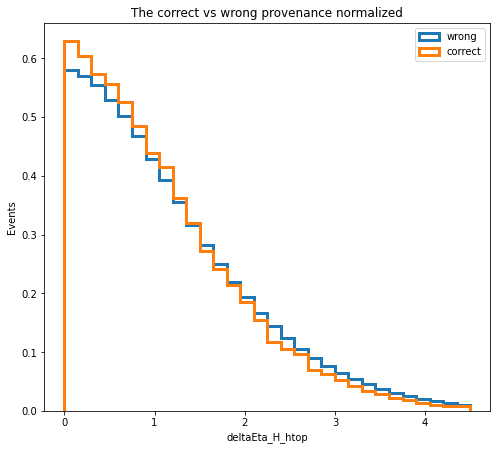

In [105]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].deltaEta_H_htop, histtype = "step", linewidth=3.0, bins=30, range=(0,4.5), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].deltaEta_H_htop, histtype = "step", linewidth=3.0, bins=30, range=(0,4.5), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('deltaEta_H_htop')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'deltaEta_H_ltop'

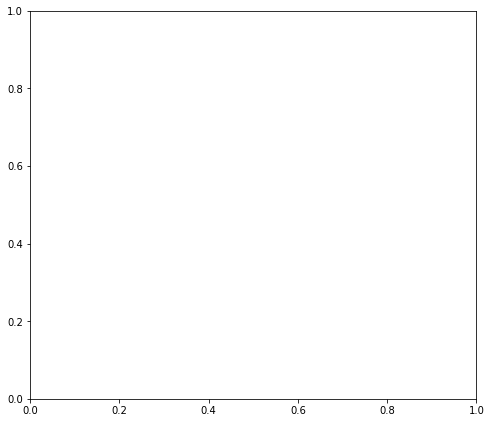

In [106]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].deltaEta_H_ltop, histtype = "step", linewidth=3.0, bins=30, range=(0,5), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].deltaEta_H_ltop, histtype = "step", linewidth=3.0, bins=30, range=(0,5), label="correct",density=True)
plt.ylabel('Events')
plt.xlabel('deltaEta_H_ltop')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

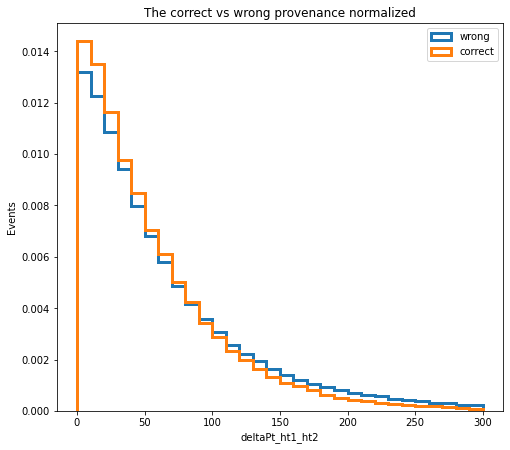

In [107]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].deltaPt_ht1_ht2, histtype = "step", linewidth=3.0, bins=30, range=(0,300), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].deltaPt_ht1_ht2, histtype = "step", linewidth=3.0, bins=30, range=(0,300), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('deltaPt_ht1_ht2')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()


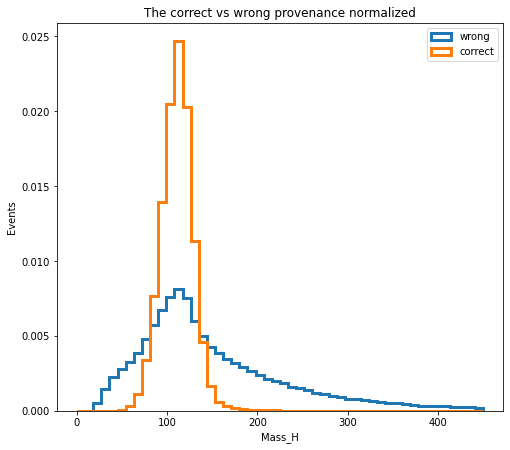

In [108]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].Mass_H, histtype = "step", linewidth=3.0, bins=50, range=(0,450), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].Mass_H, histtype = "step", linewidth=3.0, bins=50, range=(0,450), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('Mass_H')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

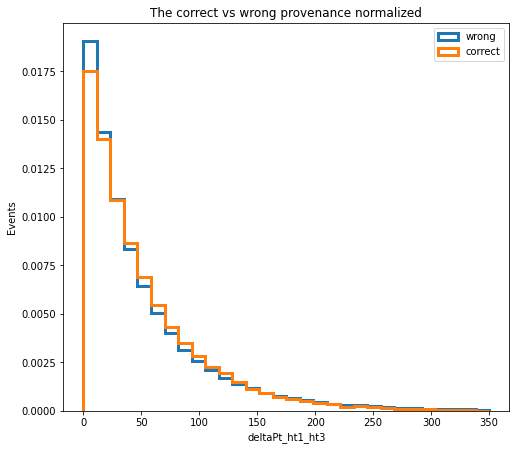

In [109]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
dist1 = training_data[training_data.y==0].Mass_H
dist2 = training_data[training_data.y==1].Mass_H
plt.hist(training_data[training_data.y==0].deltaPt_ht1_ht3, histtype = "step", linewidth=3.0, bins=30, range=(0,350), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].deltaPt_ht1_ht3, histtype = "step", linewidth=3.0, bins=30, range=(0,350), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('deltaPt_ht1_ht3')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'Eta_htop'

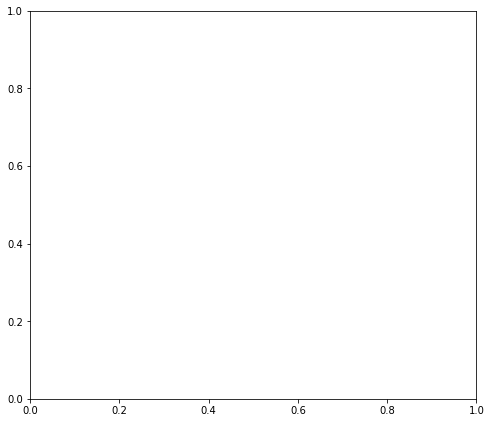

In [111]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].Eta_htop, histtype = "step", linewidth=3.0, bins=30, range=(-4,4), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].Eta_htop, histtype = "step", linewidth=3.0, bins=30, range=(-4,4), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('Eta_htop')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

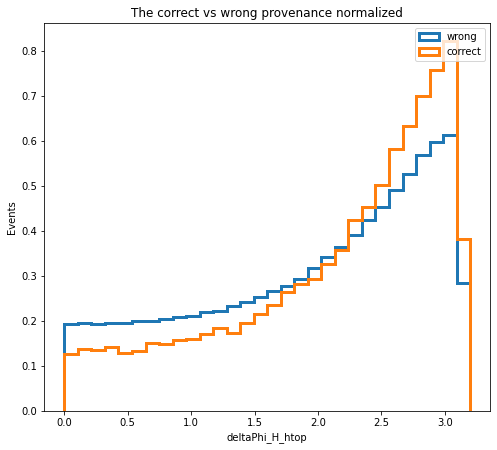

In [112]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].deltaPhi_H_htop, histtype = "step", linewidth=3.0, bins=30, range=(0,3.2), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].deltaPhi_H_htop, histtype = "step", linewidth=3.0, bins=30, range=(0,3.2), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('deltaPhi_H_htop')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

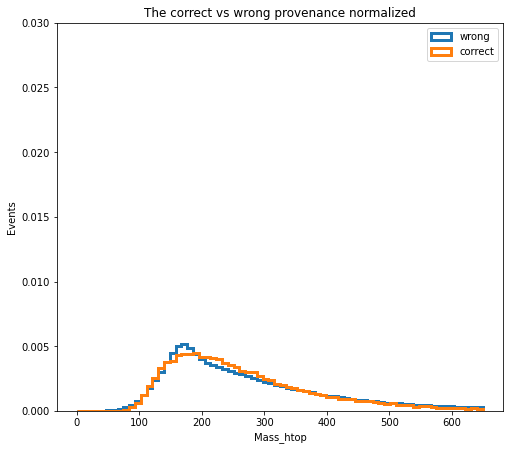

In [119]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].Mass_htop, histtype = "step", linewidth=3.0, bins=70, range=(0,650), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].Mass_htop, histtype = "step", linewidth=3.0, bins=70, range=(0,650), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('Mass_htop')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.ylim(0, 0.03)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'deltaEta_ht1_ht3'

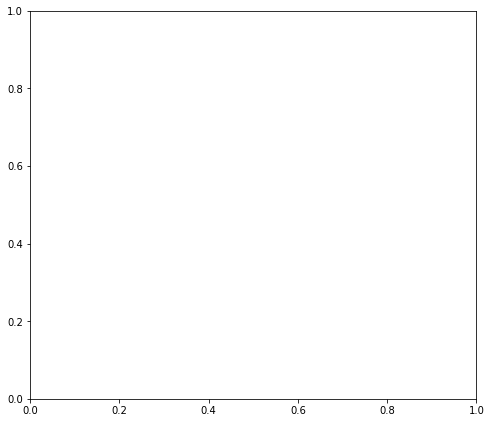

In [120]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].deltaEta_ht1_ht3, histtype = "step", linewidth=3.0, bins=30, range=(0,4), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].deltaEta_ht1_ht3, histtype = "step", linewidth=3.0, bins=30, range=(0,4),  label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('deltaEta_ht1_ht3')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

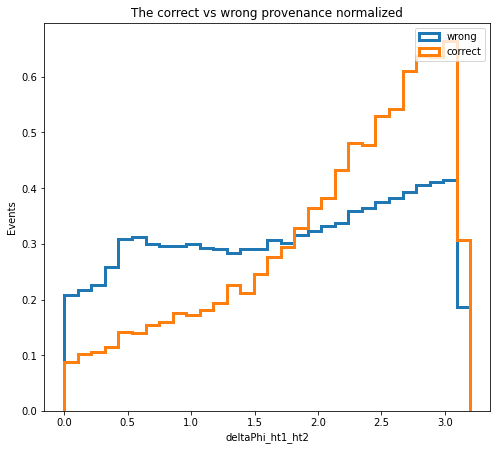

In [121]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].deltaPhi_ht1_ht2, histtype = "step", linewidth=3.0, bins=30, range=(0,3.2), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].deltaPhi_ht1_ht2, histtype = "step", linewidth=3.0, bins=30, range=(0,3.2), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('deltaPhi_ht1_ht2')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'deltaEta_ht2_ltop'

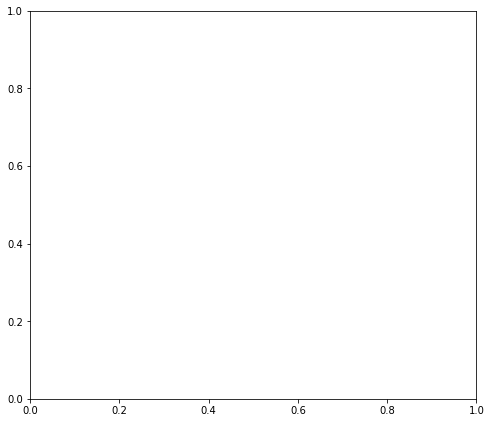

In [122]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].deltaEta_ht2_ltop, histtype = "step", linewidth=3.0, bins=30, range=(0,4), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].deltaEta_ht2_ltop, histtype = "step", linewidth=3.0, bins=30, range=(0,4), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('deltaEta_ht2_ltop')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

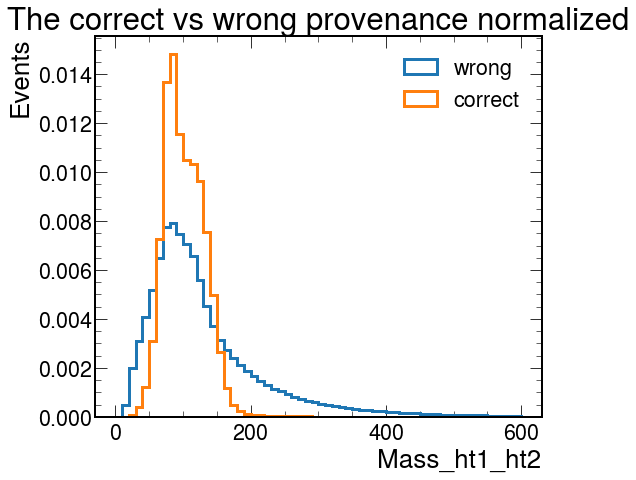

In [75]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].Mass_ht1_ht2, histtype = "step", linewidth=3.0, bins=60, range=(0,600), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].Mass_ht1_ht2, histtype = "step", linewidth=3.0, bins=60, range=(0,600), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('Mass_ht1_ht2')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

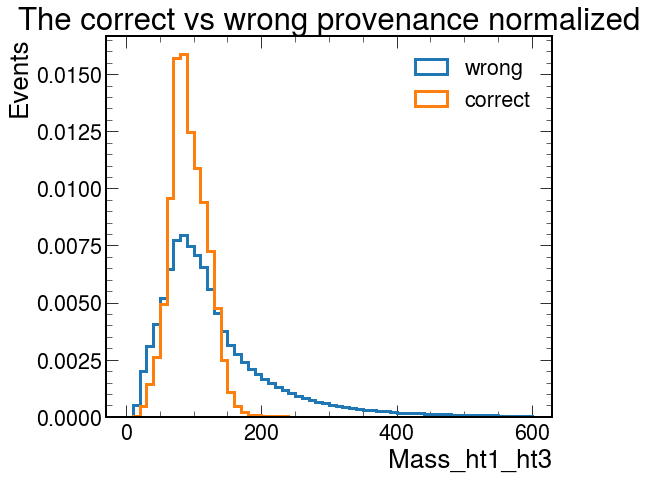

In [76]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].Mass_ht1_ht3, histtype = "step", linewidth=3.0, bins=60, range=(0,600), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].Mass_ht1_ht3, histtype = "step", linewidth=3.0, bins=60, range=(0,600), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('Mass_ht1_ht3')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

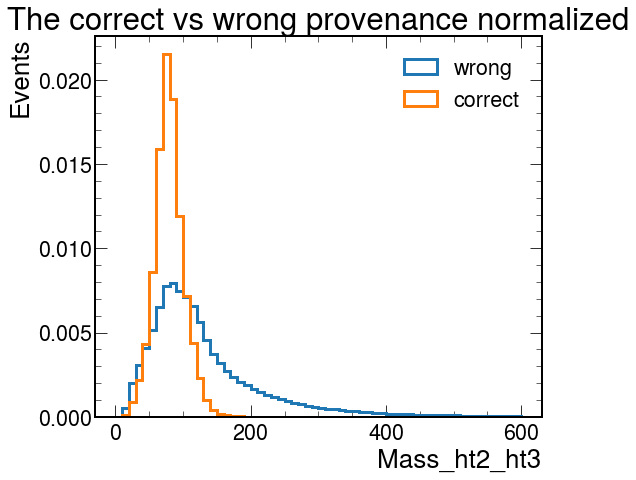

In [77]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].Mass_ht2_ht3, histtype = "step", linewidth=3.0, bins=60, range=(0,600), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].Mass_ht2_ht3, histtype = "step", linewidth=3.0, bins=60, range=(0,600), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('Mass_ht2_ht3')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

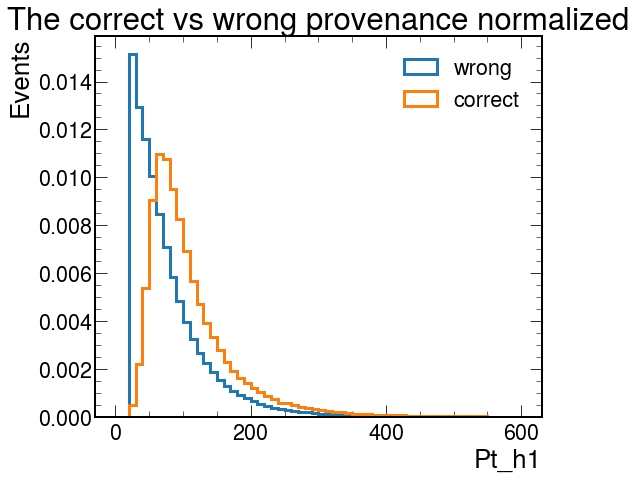

In [36]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(training_data[training_data.y==0].Pt_h1, histtype = "step", linewidth=3.0, bins=60, range=(0,600), label="wrong", density=True)
plt.hist(training_data[training_data.y==1].Pt_h1, histtype = "step", linewidth=3.0, bins=60, range=(0,600), label="correct", density=True)
plt.ylabel('Events')
plt.xlabel('Pt_h1')
plt.title('The correct vs wrong provenance normalized')
plt.legend()
plt.show()

In [68]:
corr_matrix = training_data.corr(method='pearson')

In [69]:
corr_matrix

,deltaEta_H_htop,deltaEta_htop_ltop,deltaPhi_H_htop,deltaPhi_H_ltop,deltaPhi_htop_ltop,Eta_H,Phi_H,Pt_H,Phi_htop,Pt_htop,...,deltaEta_h2_ht3,deltaPt_h1_ht2,deltaPt_h2_ht3,deltaPt_ht2_ltop,deltaPt_ht3_ltop,deltaPhi_ht3_ltop,Mass_ht1_ht2,Mass_ht1_ht3,Mass_ht2_ht3,y
deltaEta_H_htop,1.000000,0.299874,-0.000091,0.001859,-0.000969,0.002532,0.000118,-0.131934,0.000563,-0.169621,...,0.296973,-0.021005,-0.013521,-0.011368,-0.013462,0.000844,0.074040,0.072955,0.075165,-0.039020
deltaEta_htop_ltop,0.299874,1.000000,0.000461,-0.000027,-0.000303,0.001255,0.000133,-0.021023,0.000465,-0.204316,...,0.066599,-0.007563,-0.009576,-0.023928,-0.026436,0.000943,0.080724,0.079824,0.079640,-0.007711
deltaPhi_H_htop,-0.000091,0.000461,1.000000,-0.147611,0.128700,0.001314,-0.003046,-0.000647,0.002475,0.000258,...,-0.001138,0.001126,-0.000412,0.000276,-0.000160,0.052822,0.000586,0.000020,0.000161,0.000770
deltaPhi_H_ltop,0.001859,-0.000027,-0.147611,1.000000,-0.169635,-0.000657,-0.001650,-0.000346,-0.001246,-0.000327,...,0.000261,0.000216,-0.000699,-0.000873,-0.001683,-0.086522,-0.000894,-0.001486,-0.000579,0.000192
deltaPhi_htop_ltop,-0.000969,-0.000303,0.128700,-0.169635,1.000000,-0.000915,0.000310,0.000685,-0.000956,-0.000704,...,-0.000244,-0.000184,0.000019,0.001241,0.001740,0.261707,-0.000433,-0.000074,0.000483,-0.000620
Eta_H,0.002532,0.001255,0.001314,-0.000657,-0.000915,1.000000,-0.000436,-0.001468,-0.001227,-0.002700,...,0.001810,-0.001171,-0.000907,0.000172,-0.000287,0.001238,-0.000099,-0.001708,-0.000198,0.000133
Phi_H,0.000118,0.000133,-0.003046,-0.001650,0.000310,-0.000436,1.000000,-0.001132,-0.133971,0.000573,...,0.000577,-0.000700,0.001233,0.001619,0.001233,-0.000057,0.001079,0.001236,0.001985,-0.000178
Pt_H,-0.131934,-0.021023,-0.000647,-0.000346,0.000685,-0.001468,-0.001132,1.000000,0.001243,0.212049,...,-0.034921,0.406463,0.343473,0.129514,0.128856,-0.000336,0.049855,0.047562,0.044648,0.064776
Phi_htop,0.000563,0.000465,0.002475,-0.001246,-0.000956,-0.001227,-0.133971,0.001243,1.000000,0.000502,...,0.000833,-0.001630,-0.000489,-0.001215,-0.000217,-0.000588,-0.000888,-0.001236,-0.001465,0.000989
Pt_htop,-0.169621,-0.204316,0.000258,-0.000327,-0.000704,-0.002700,0.000573,0.212049,0.000502,1.000000,...,-0.018447,0.264552,0.239842,0.268884,0.270231,0.000046,0.157120,0.153855,0.143890,0.185565


<Figure size 12000x12000 with 0 Axes>

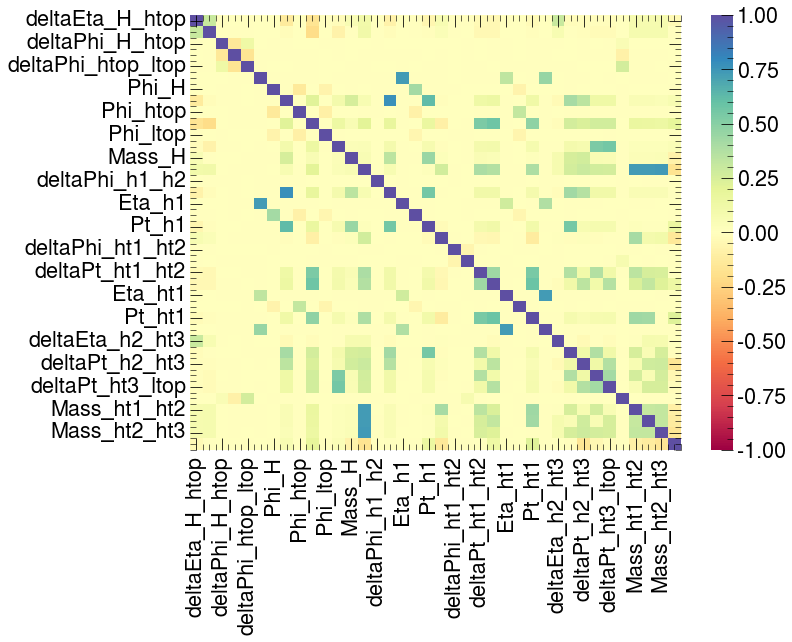

In [70]:
rs = np.random.RandomState(0)
plt.figure(figsize=(40,40), dpi=300)
corr = corr_matrix
plt.figure(figsize=(11,8))
sns.heatmap(corr,cmap = 'Spectral' , annot=False, vmin=-1, vmax=1)
plt.show()

# Building and training a DNN on the training dataset

## Building a simple DNN

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [84]:
device = torch.device("cpu")

In [85]:
# We will be using the training dataset constructed before

training_data_1, training_data_0 = get_training_data(jets_fullymatched, 1)
training_data = pd.concat([training_data_1, training_data_0]).reset_index(drop=True)

In [82]:
# Saving on disk

training_data.to_csv('training_data.csv', index=False)

In [86]:
training_data.to_csv('training_data1.csv', index=False)

In [4]:
# Reading on disk

training_data = pd.read_csv('training_data.csv')

In [36]:
training_data

,deltaEta_H_htop,deltaEta_htop_ltop,deltaPhi_H_htop,deltaPhi_H_ltop,deltaPhi_htop_ltop,Eta_H,Phi_H,Pt_H,Phi_htop,Pt_htop,...,deltaEta_h2_ht3,deltaPt_h1_ht2,deltaPt_h2_ht3,deltaPt_ht2_ltop,deltaPt_ht3_ltop,deltaPhi_ht3_ltop,Mass_ht1_ht2,Mass_ht1_ht3,Mass_ht2_ht3,y
0,0.301140,0.725421,2.324386,-2.141213,1.817586,2.143749,-2.957009,166.002701,1.001790,318.222748,...,1.431885,2.187500,41.812500,21.375000,18.062500,2.317261,98.334738,80.801666,114.613730,1
1,0.778788,0.906623,-1.285229,-1.659870,-0.374641,1.616365,-0.306843,56.380836,0.978386,124.945930,...,2.024048,24.718750,4.625000,13.203125,7.203125,-1.824036,50.091846,110.511858,75.192757,1
2,0.389590,1.462423,-2.470273,0.863565,-2.949347,0.656207,-2.295597,147.654831,0.174676,317.780731,...,0.589844,6.750000,10.031250,6.625000,125.375000,1.990461,111.773815,101.442226,85.096222,1
3,0.350333,1.898866,1.987569,-3.037939,1.257677,-0.402031,0.683723,161.167068,-1.303846,205.763428,...,1.219299,63.343750,23.750000,53.718750,64.812500,0.437012,99.276011,90.659414,93.860946,1
4,2.239024,0.180354,-1.701985,-2.246475,-0.544490,4.048284,2.911955,14.770351,-1.669246,60.590450,...,1.618835,4.593750,28.468750,36.875000,61.625000,-0.783936,111.947747,62.656573,55.222729,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927569,2.358367,2.506589,1.119127,1.709219,0.590092,1.592257,-0.349863,72.153143,-1.468990,60.750389,...,2.864746,76.453125,55.093750,70.125000,10.718750,-1.012207,101.738620,56.870986,139.807149,0
1927570,0.794082,2.118517,1.543441,2.176009,0.632567,0.124971,-0.895280,73.834661,-2.438722,44.179645,...,1.612274,22.109375,49.406250,8.218750,10.000000,2.317383,61.312339,206.253737,143.235389,0
1927571,0.946273,1.356992,-3.085341,-1.372505,1.712836,-0.788744,1.839391,18.078336,-1.358453,102.502621,...,1.822784,25.265625,18.000000,17.046875,10.718750,1.012207,141.440296,115.452193,157.200925,0
1927572,0.302085,2.137841,-0.900846,2.763907,-2.618433,1.592257,-0.349863,72.153143,0.550983,149.574418,...,0.276123,27.046875,9.937500,1.781250,56.812500,-2.066633,111.704547,175.193206,117.631649,0


In [5]:
# Shuffling and separating x-s and y-s

training_data = training_data.sample(frac=1, random_state=1).reset_index(drop=True)
training_data = training_data.values
x = training_data[:,0:-1]
y = training_data[:,-1]

In [6]:
# Splitting the dataset

X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)
X_train, x_valid, Y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train)

In [89]:
# Saving the testing dataset to disk

pd.DataFrame(x_test).to_csv("x_test.csv", index=False)
pd.DataFrame(y_test).to_csv("y_test.csv", index=False)

In [7]:
# Feature scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
x_valid = sc.fit_transform(x_valid)

In [8]:
# Defining dataset class

class dataset(Dataset):
        
    def __init__(self, x, y, w):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.w = torch.tensor(w,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self, idx):
        return self.x[idx],self.y[idx],self.w[idx]
    
    def __len__(self):
        return self.length


In [9]:
class Net(nn.Module):
    
    def __init__(self, input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,16)
        self.fc2 = nn.Linear(16,16)
        self.fc3 = nn.Linear(16,1)
        #self.fc4 = nn.Linear(16,16)
        #self.fc5 = nn.Linear(16,16)
        #self.fc6 = nn.Linear(16,1)
        
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))
        #x = self.elu(self.fc4(x))
        #x = self.elu(self.fc5(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [10]:
def weights(targets, num_perms):
    weight = np.ones(len(targets))
    for i in range(len(targets)):
        if targets[i] == 0:
            weight[i] = 1/num_perms 
    return weight

In [13]:
# Hyper parameters

learning_rate = 1
epochs = 200
eps = 0.001 #stoppage criterium for validation loss
eps1 = 0.00005

# Model, Optimizer, Loss

w = weights(Y_train, 1)
model = Net(input_shape=X_train.shape[1])
model.to(device)
train_set = dataset(X_train, Y_train, w)
valid_set = dataset(x_valid, y_valid, w)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.9)

# DataLoader
trainloader = DataLoader(train_set, batch_size=100, shuffle=False)
validloader = DataLoader(valid_set, batch_size=50, shuffle=False)

## Training

In [104]:
*#forward loop

losses = []
vlosses = []

for i in range(epochs):
    print(i)
    train_loss = 0
    for j, (x_train, y_train, w_train) in enumerate(trainloader):
        
        x_train, y_train, w_train = x_train.to(device), y_train.to(device), w_train.to(device)
        #calculate output
        output = model(x_train)
        
        #calculate loss
        loss_fn = nn.BCELoss(weight = w_train.reshape(-1,1)) 
        loss = loss_fn(output, y_train.reshape(-1,1))
 
        #accuracy
        #predicted = model(torch.tensor(x,dtype=torch.float32).to(device))
        #acc = (predicted.cpu().reshape(-1).detach().numpy().round() == y).mean()
    
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()/len(trainloader)
    
    valid_loss = 0
    for j, (x_valids, y_valids, w_valids) in enumerate(validloader):

        x_valids, y_valids, w_valids = x_valids.to(device), y_valids.to(device), w_valids.to(device) 
         
        # Forward Pass
        output = model(x_valids)
        
        # Find the Loss
        loss_fn = nn.BCELoss(weight = w_valids.reshape(-1,1)) 
        
        # Calculate Loss
        vloss = loss_fn(output, y_valids.reshape(-1,1))
        
        valid_loss += vloss.item()/len(validloader)
    
    scheduler.step()
    losses.append(train_loss)
    vlosses.append(valid_loss)
    print("epoch {}\tloss : {}\t vloss : {}".format(i,train_loss,valid_loss))
    
    if i>2:
        if valid_loss<eps or abs(vlosses[-1]-vlosses[-2])<eps1:
            break

0
epoch 0	loss : 0.16264357806211632	 vloss : 0.13955038845776874
1
epoch 1	loss : 0.12981601032176154	 vloss : 0.12387396735832719
2
epoch 2	loss : 0.11796615598004614	 vloss : 0.11385107078450797
3
epoch 3	loss : 0.1107814108200485	 vloss : 0.10813700272206303
4
epoch 4	loss : 0.10657958160816207	 vloss : 0.10419479194988922
5
epoch 5	loss : 0.10371640177186883	 vloss : 0.10179525111861364
6
epoch 6	loss : 0.10155078016138276	 vloss : 0.09963862239085938
7
epoch 7	loss : 0.099730260455074	 vloss : 0.09788372861815903
8
epoch 8	loss : 0.0982124564040131	 vloss : 0.09639037059560573
9
epoch 9	loss : 0.09689386904650073	 vloss : 0.09501871389257621
10
epoch 10	loss : 0.09576126198448372	 vloss : 0.09374701294235575
11
epoch 11	loss : 0.09478313975262165	 vloss : 0.0926684782493542
12
epoch 12	loss : 0.093909606205705	 vloss : 0.09170238534087675
13
epoch 13	loss : 0.0931255204252158	 vloss : 0.09082973689593851
14
epoch 14	loss : 0.09242202990954546	 vloss : 0.09006806359368741
15
epoch

Text(0, 1, 'loss')

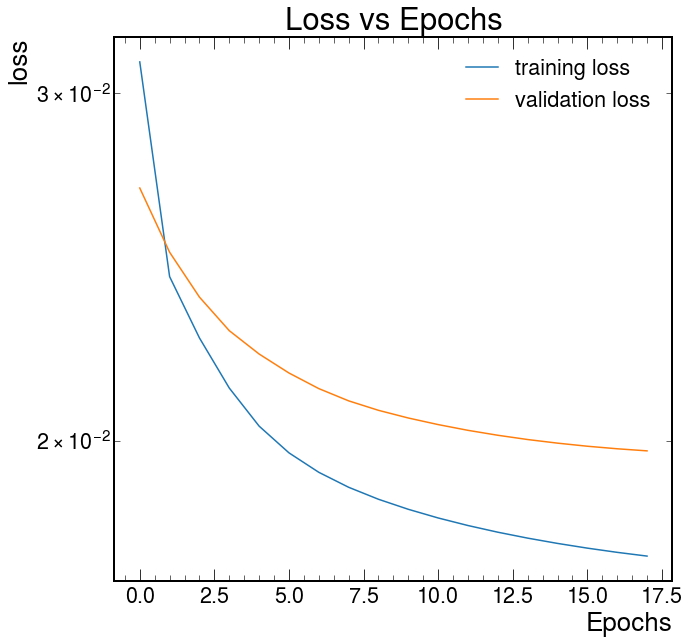

In [55]:
#plotting the loss
plt.plot(np.array(losses), label='training loss' )
plt.plot(np.array(vlosses), label='validation loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 1, 'loss')

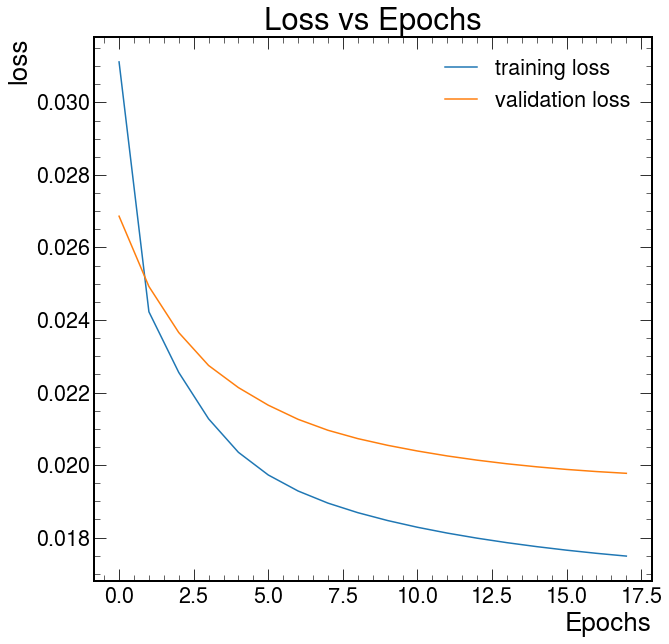

In [56]:
#plotting the loss
plt.plot(np.array(losses), label='training loss' )
plt.plot(np.array(vlosses), label='validation loss')
plt.title('Loss vs Epochs')
plt.legend()
#plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('loss')

In [64]:
model.to('cpu')

Net(
  (fc1): Linear(in_features=36, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [57]:
torch.save(model.state_dict(), 'model.pt')

## Testing the performance and efficiency

In [58]:
model1 = Net(input_shape=x_train.shape[1])
model1.load_state_dict(torch.load('model.pt'))
model1.eval()

Net(
  (fc1): Linear(in_features=36, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
)

In [59]:
model1.to(device)

Net(
  (fc1): Linear(in_features=36, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
)

In [60]:
x_test, y_test = pd.read_csv('x_test.csv'), pd.read_csv('y_test.csv') 

In [61]:
x_test, y_test = x_test.values, y_test.values

In [62]:
x_test = sc.transform(x_test)

In [63]:
x_test, y_test = torch.tensor(x_test,dtype=torch.float32).to(device), torch.tensor(y_test,dtype=torch.float32).to(device)

In [64]:
y_preds = model1(x_test)
y_true = y_test

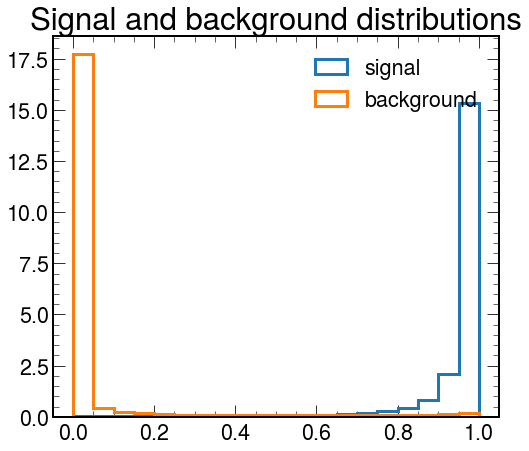

In [65]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(y_preds[y_true == 1].to('cpu').detach().numpy(), histtype = "step", linewidth=3.0, label="signal", bins=20, density=True)
plt.hist(y_preds[y_true==0].to('cpu').detach().numpy(), histtype = "step", linewidth=3.0, label="background", bins=20, density=True)
plt.ylabel('')
plt.xlabel('')
#plt.yscale('log')
plt.title('Signal and background distributions')
plt.legend()
plt.show()

In [67]:
x_test_numpy = x_test.to('cpu').detach().numpy()
y_test_numpy = y_test.to('cpu').detach().numpy()

KeyboardInterrupt: 

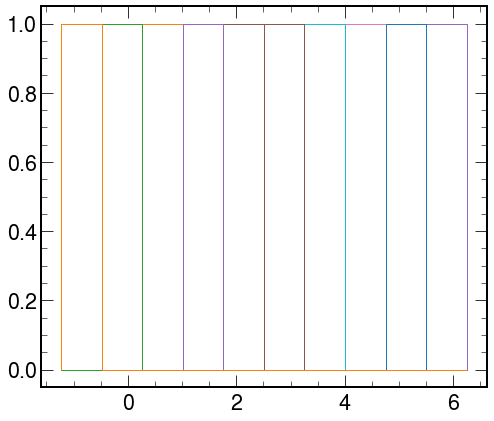

In [68]:
fig, ax = plt.subplots(figsize =(8,7), dpi=72)
plt.hist(x_test[:,0][y_test_numpy.reshape(-1,)==1], histtype = "step", linewidth=3.0, label="signal", bins=10)
plt.hist(x_test[:,0][y_test_numpy.reshape(-1,)==0], histtype = "step", linewidth=3.0, label="background", bins=10)
plt.ylabel('')
plt.xlabel('')
#plt.yscale('log')
plt.title('Signal and background distributions')
plt.legend()
plt.show()

/tmp/ipykernel_960/2785840742.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize =(8,7), dpi=72)


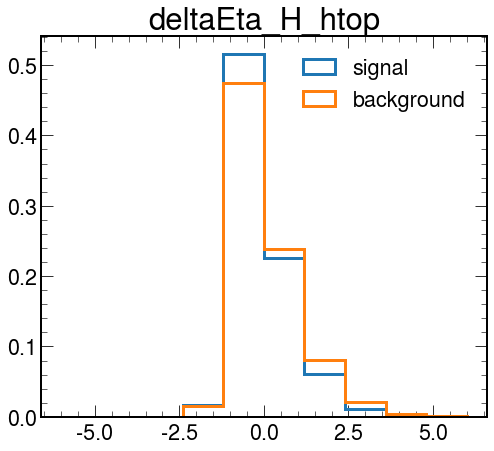

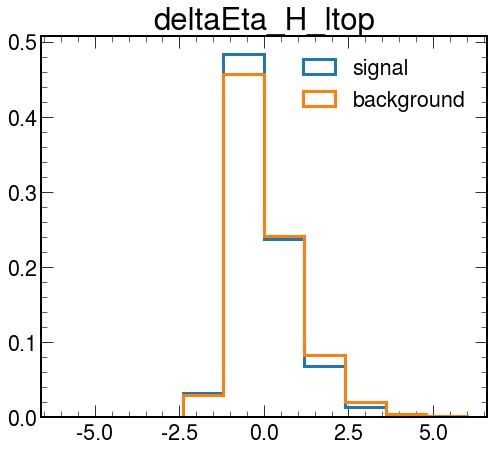

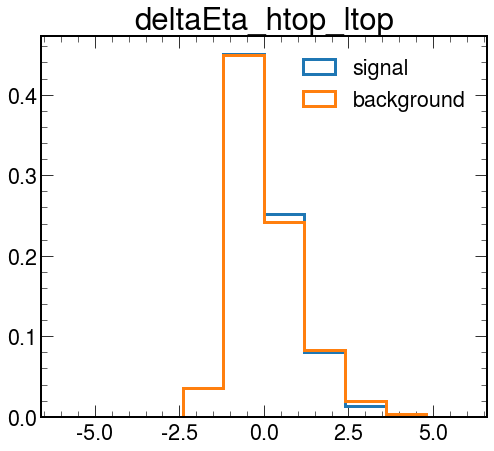

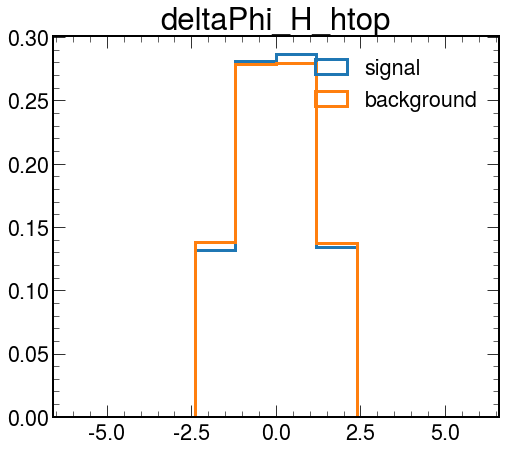

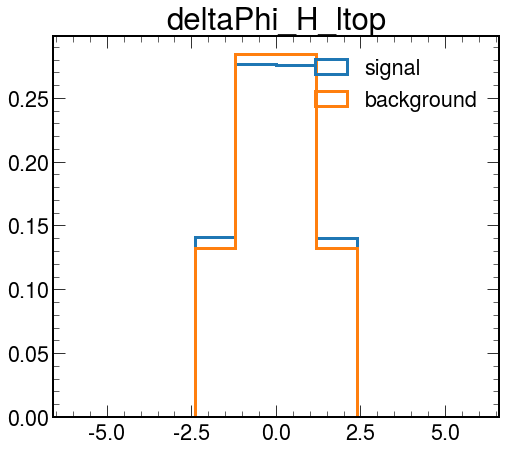

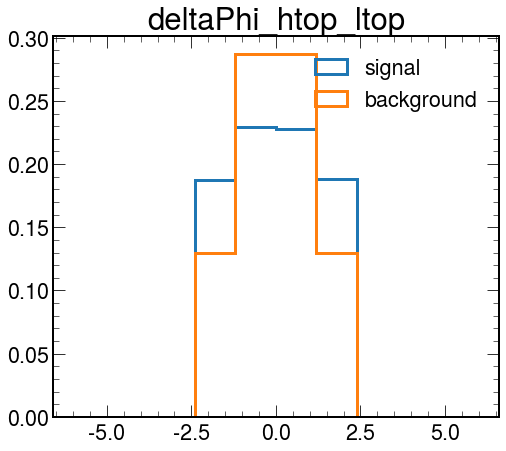

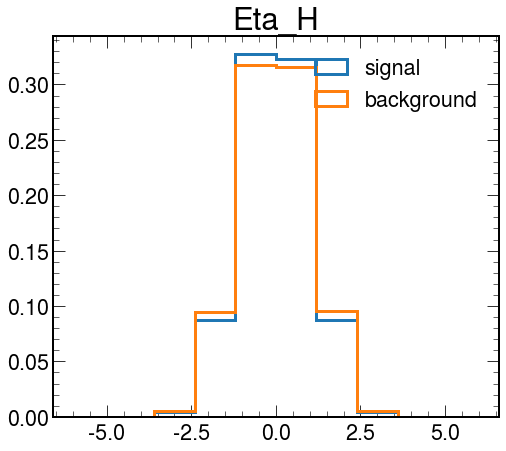

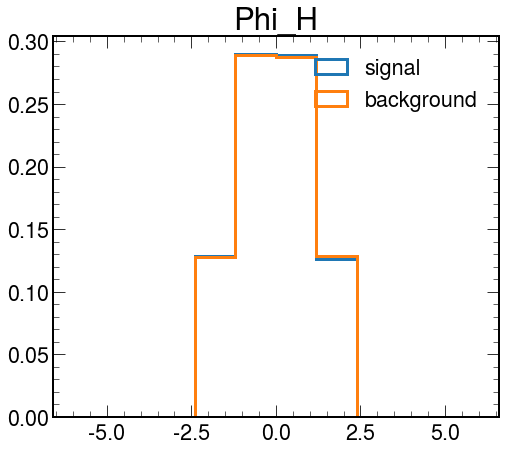

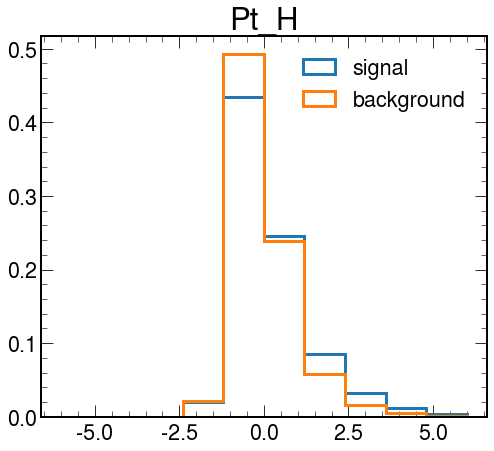

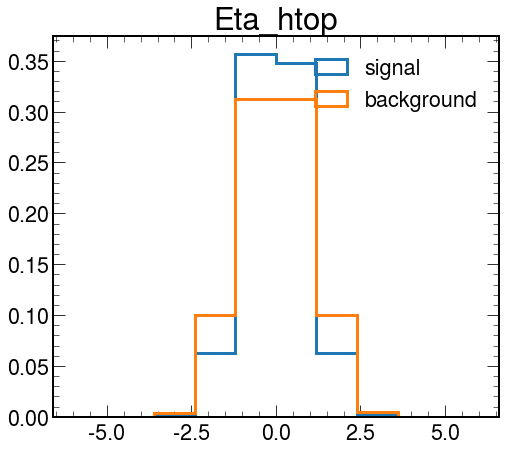

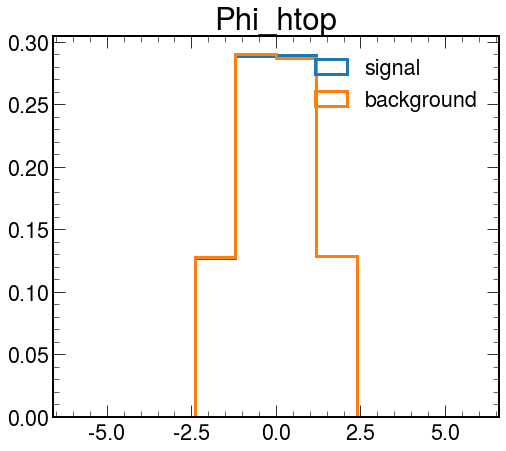

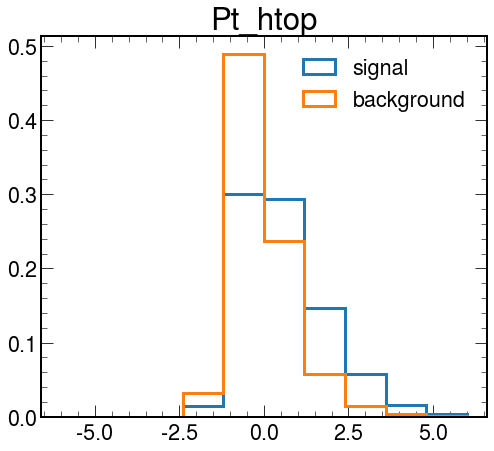

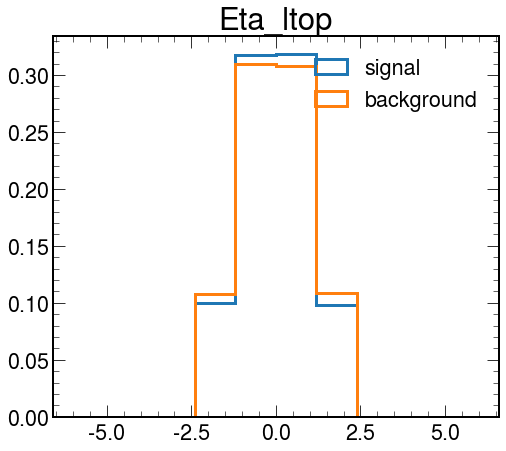

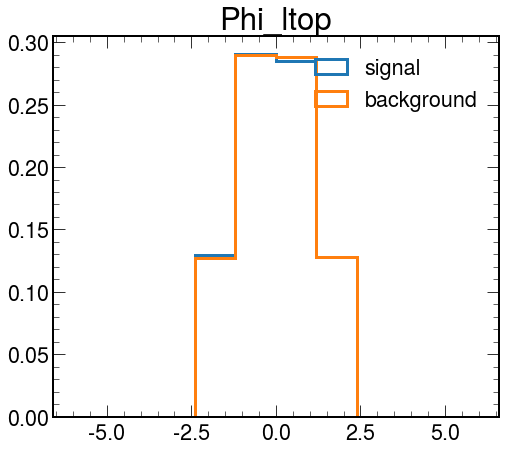

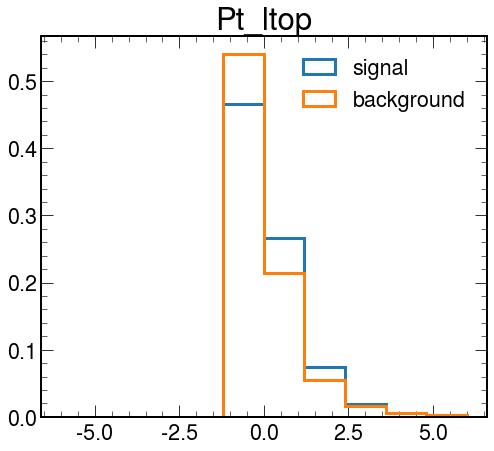

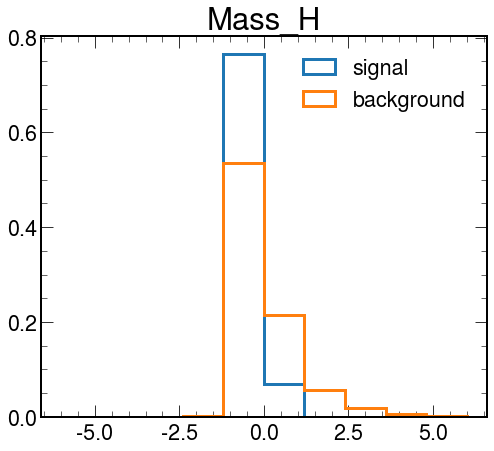

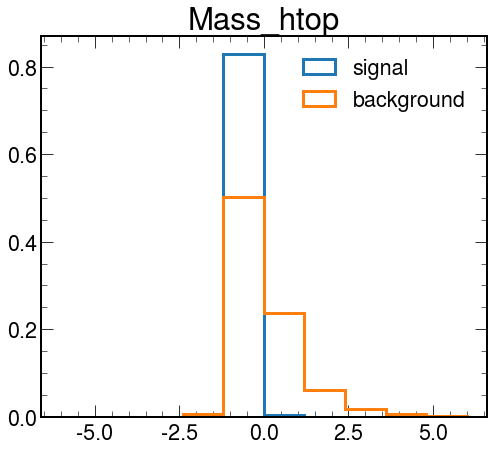

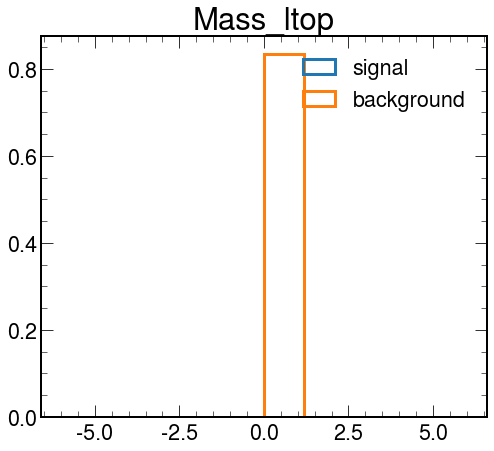

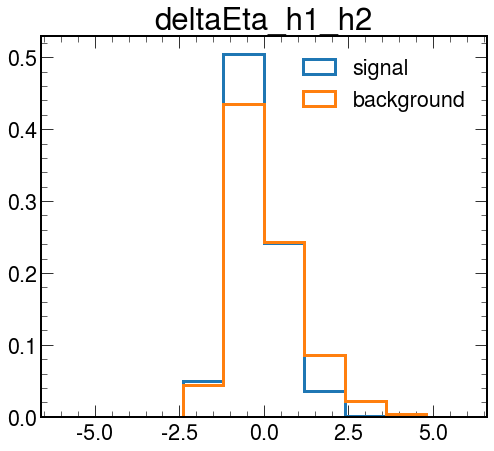

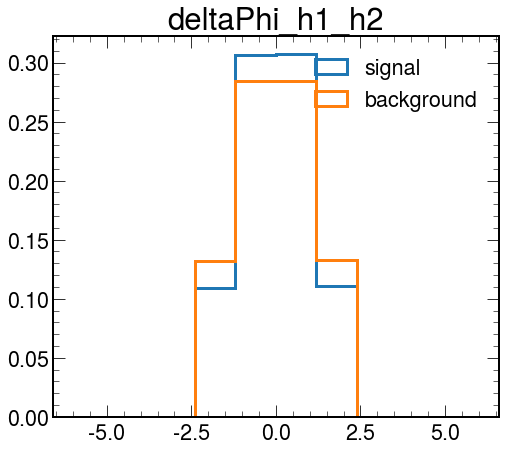

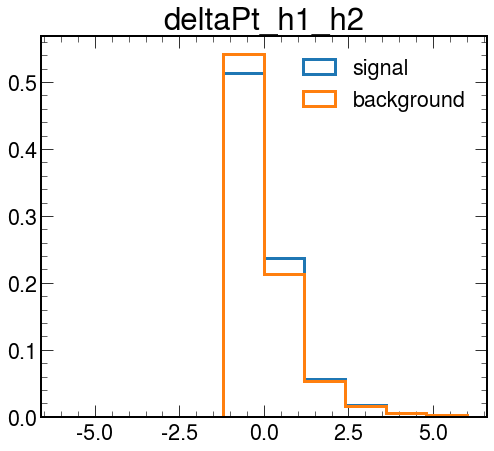

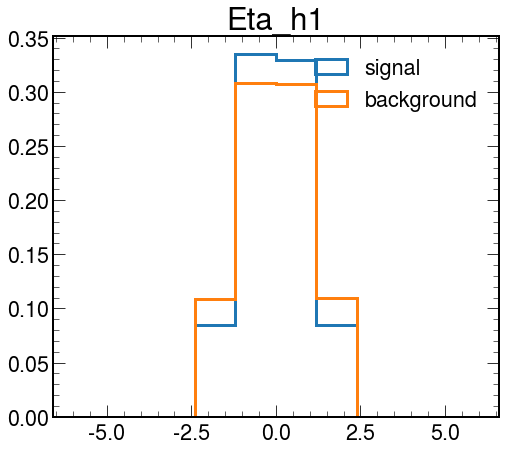

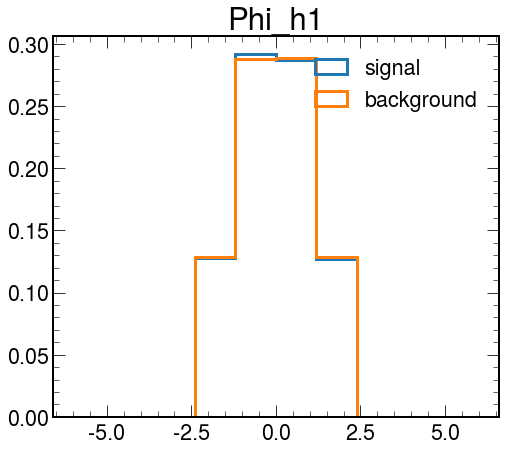

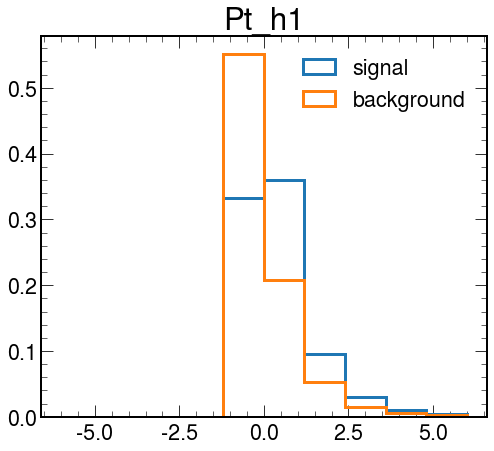

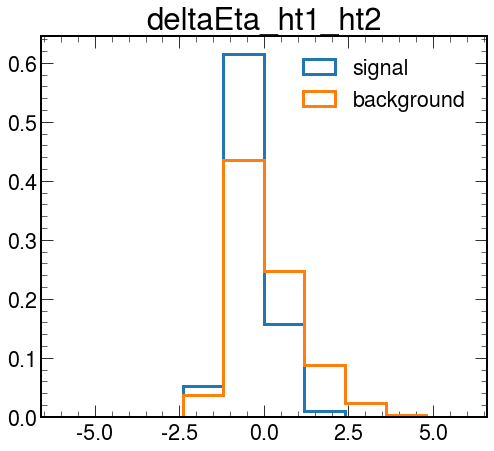

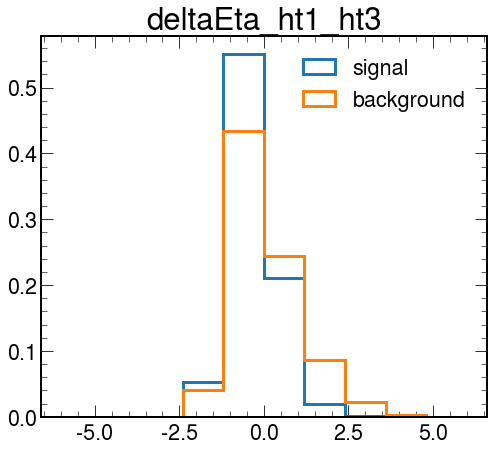

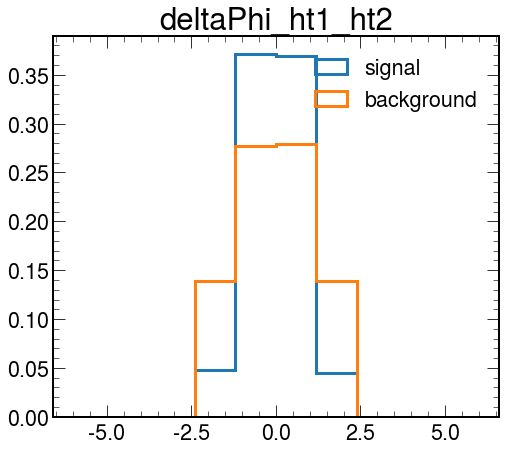

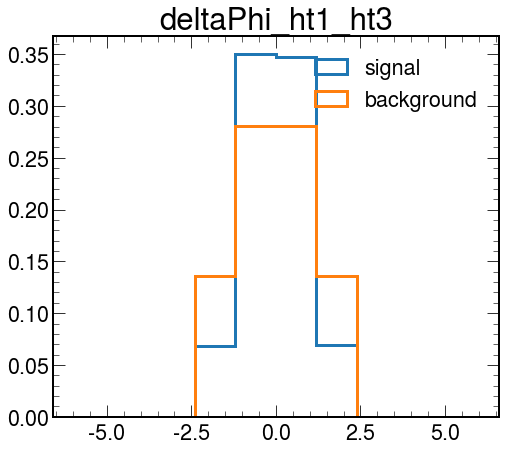

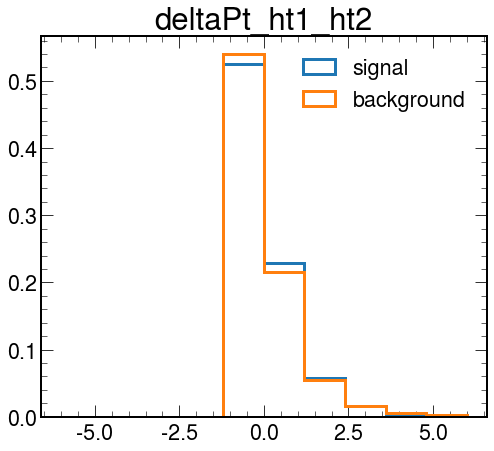

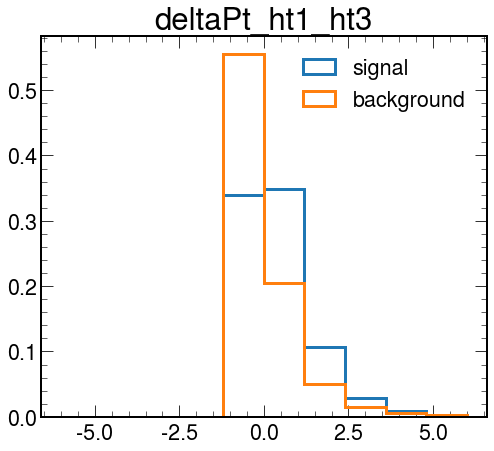

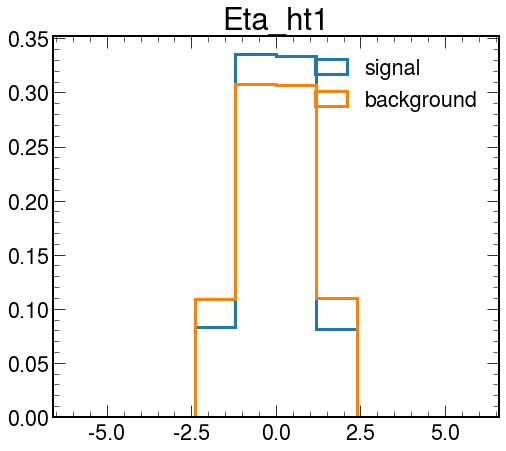

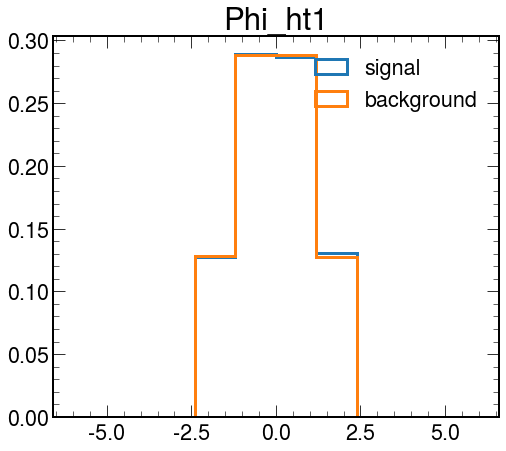

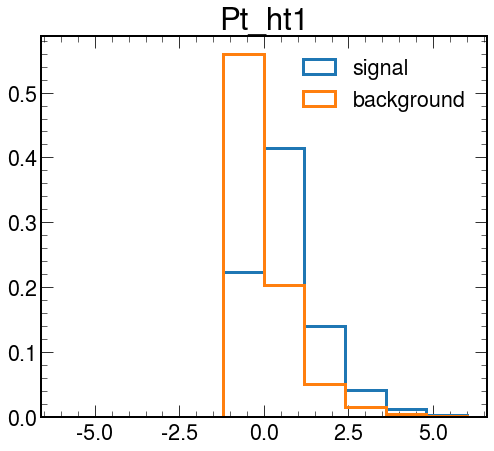

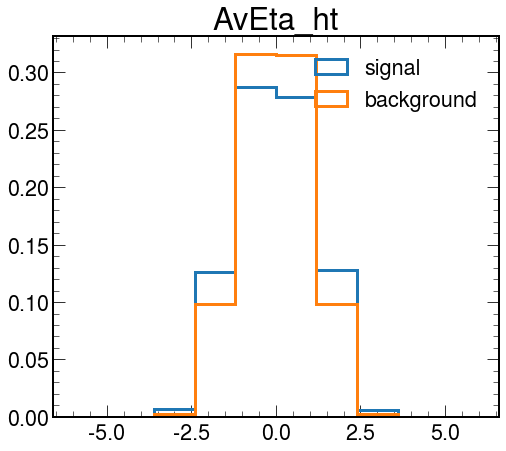

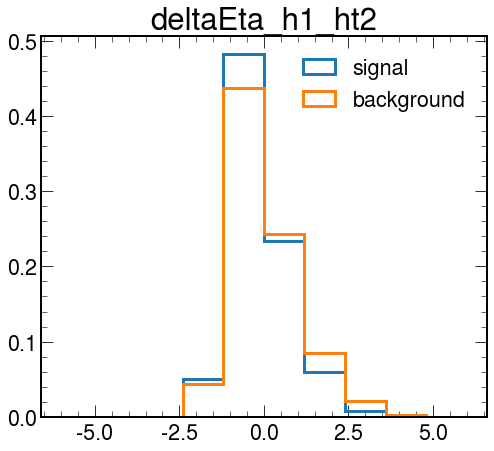

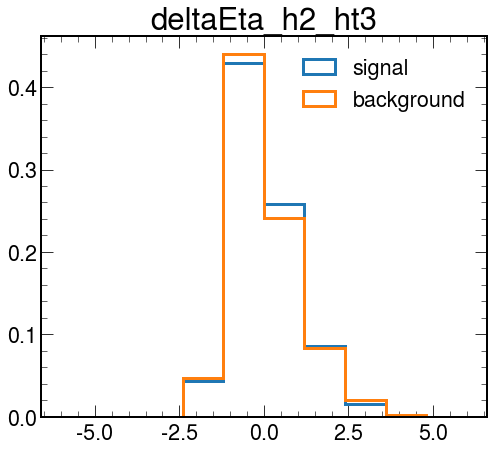

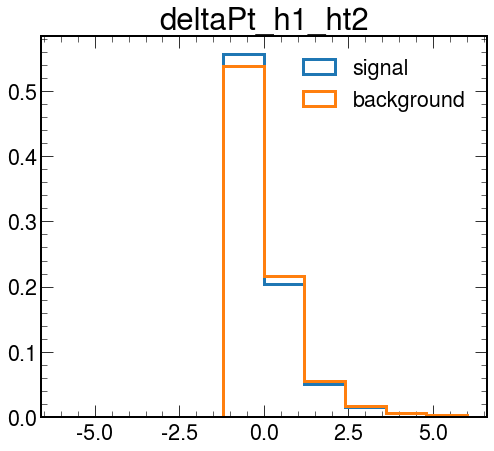

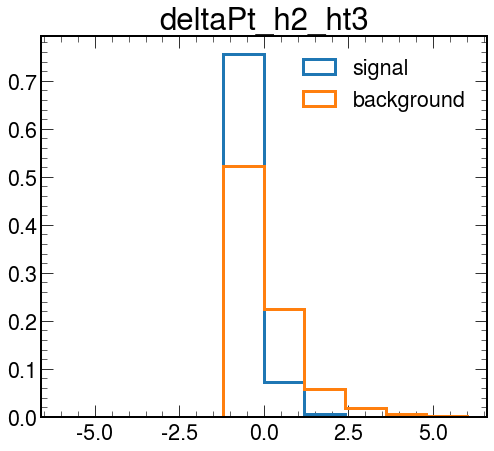

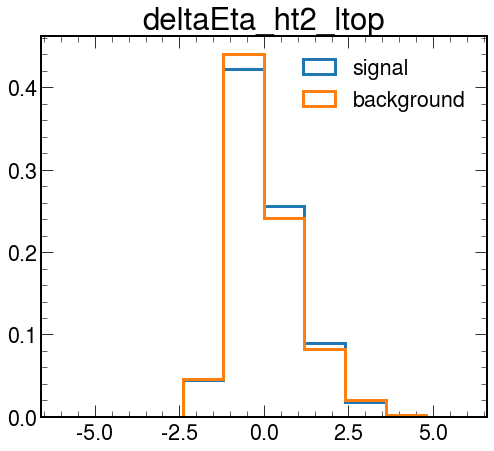

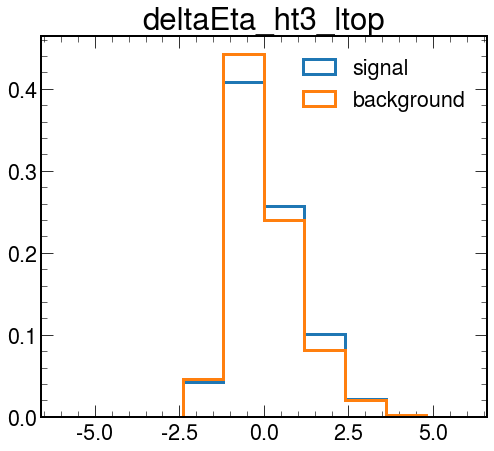

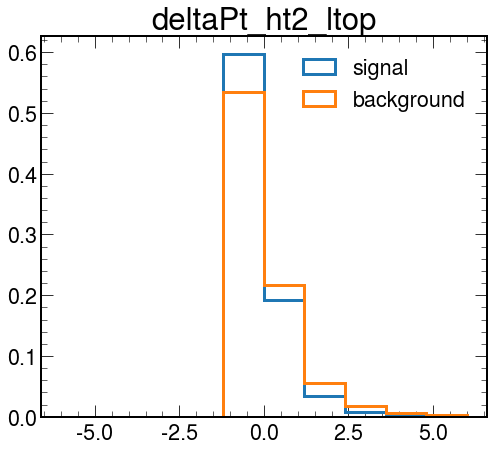

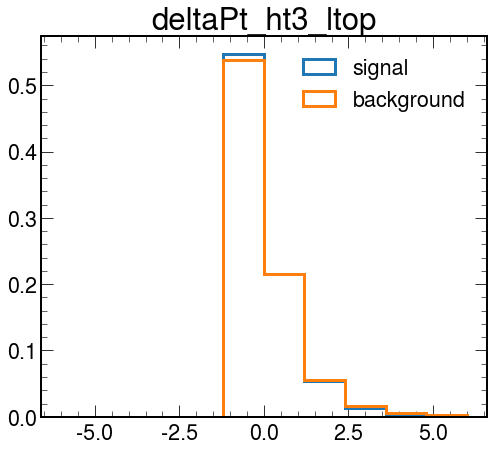

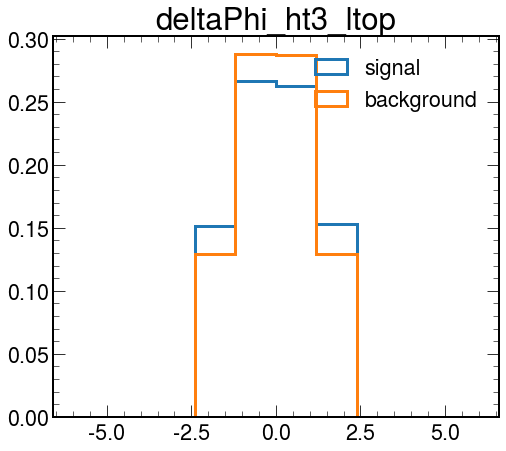

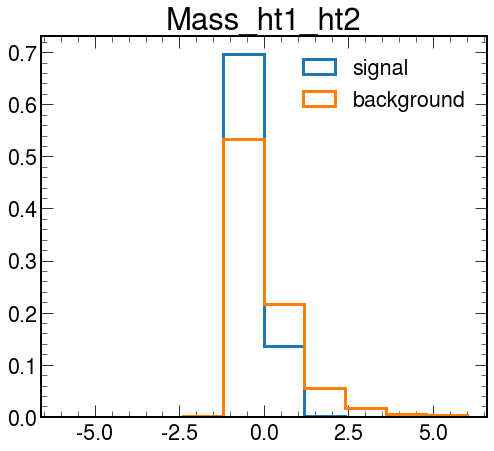

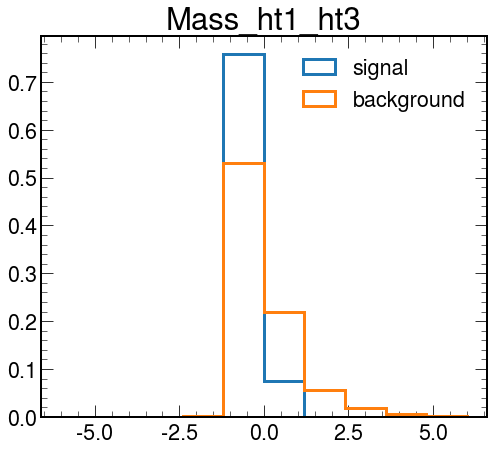

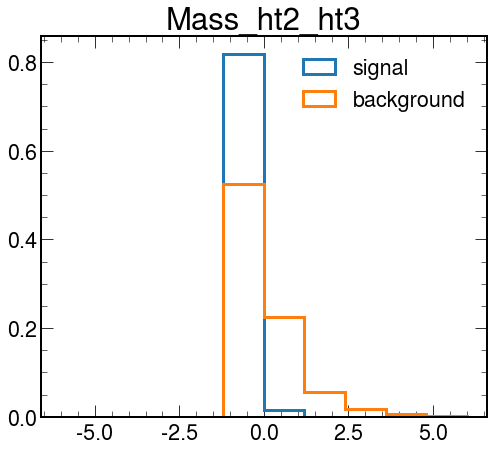

In [47]:
pdf = matplotlib.backends.backend_pdf.PdfPages("output_transformed.pdf")
for keys in dictvar.keys():
    fig = plot(keys, dictvar[keys])
    pdf.savefig(fig)
pdf.close()


In [46]:
def plot(title, num):
    fig = plt.figure(figsize =(8,7), dpi=72)
    plt.hist(x_test[:,num][y_test.reshape(-1,)==1], histtype = "step", linewidth=3.0, label="signal", bins=10, range=(-6,6), density=True)
    plt.hist(x_test[:,num][y_test.reshape(-1,)==0], histtype = "step", linewidth=3.0, label="background", bins=10, range=(-6,6), density=True)
    plt.ylabel('')
    plt.xlabel('')
    #plt.yscale('log')
    plt.title(f'{title}')
    plt.legend()
    return fig

In [39]:
dictvar = {"deltaEta_H_htop" : 0,
        "deltaEta_H_ltop" :1,
        "deltaEta_htop_ltop" : 2,
        "deltaPhi_H_htop" : 3,
        "deltaPhi_H_ltop" : 4,
        "deltaPhi_htop_ltop" : 5,
        "Eta_H" : 6,
        "Phi_H" : 7,
        "Pt_H" : 8,
        "Eta_htop" : 9,
        "Phi_htop" : 10,
        "Pt_htop" : 11,
        "Eta_ltop" : 12,
        "Phi_ltop" : 13,
        "Pt_ltop" : 14,
        "Mass_H" : 15,
        "Mass_htop" : 16,
        "Mass_ltop" : 17,
        "deltaEta_h1_h2" :18,
        "deltaPhi_h1_h2" : 19,
        "deltaPt_h1_h2" :20,
        "Eta_h1" : 21,
        "Phi_h1" : 22,
        "Pt_h1" : 23,
        "deltaEta_ht1_ht2" : 24,
        "deltaEta_ht1_ht3" : 25,
        "deltaPhi_ht1_ht2" : 26,
        "deltaPhi_ht1_ht3" : 27,
        "deltaPt_ht1_ht2" : 28,
        "deltaPt_ht1_ht3" : 29,
        "Eta_ht1" : 30,
        "Phi_ht1" : 31,
        "Pt_ht1" : 32, 
        "AvEta_ht" : 33, 
        "deltaEta_h1_ht2" : 34,
        "deltaEta_h2_ht3" : 35,
        "deltaPt_h1_ht2" : 36, 
        "deltaPt_h2_ht3" : 37,
        "deltaEta_ht2_ltop" : 38, 
        "deltaEta_ht3_ltop" : 39,
        "deltaPt_ht2_ltop" : 40, 
        "deltaPt_ht3_ltop" : 41,
        "deltaPhi_ht3_ltop" : 42,
        "Mass_ht1_ht2" : 43,
        "Mass_ht1_ht3": 44,
        "Mass_ht2_ht3" : 45 }

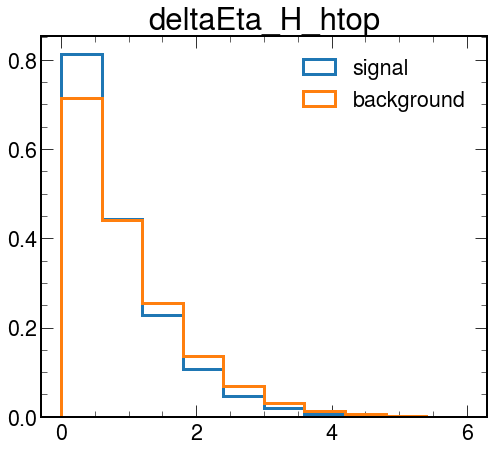

In [143]:
fig = plt.figure(figsize =(8,7), dpi=72)
plt.hist(x_test[:,0][y_test.reshape(-1,)==1], histtype = "step", linewidth=3.0, label="signal", bins=10, range=(0,6), density=True)
plt.hist(x_test[:,0][y_test.reshape(-1,)==0], histtype = "step", linewidth=3.0, label="background", bins=10, range=(0,6), density=True)
plt.ylabel('')
plt.xlabel('')
#plt.yscale('log')
plt.title(f'{key}')
plt.legend()
plt.show()



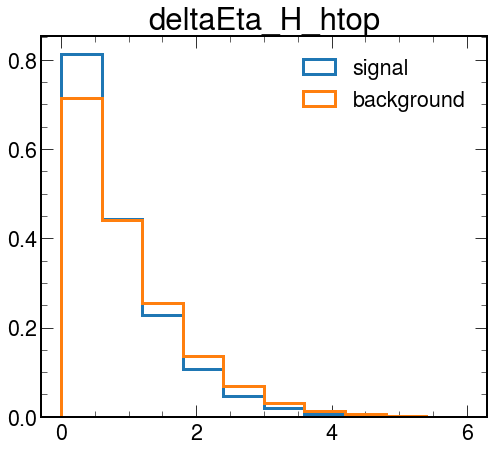

In [144]:
fig

In [119]:
x_test[:,45]

array([-1.14295098, -0.17562717,  0.38928099, ...,  0.18694018,
       -0.99821837,  0.02287401])

In [69]:
metric = BinaryROC(thresholds=None)

In [70]:
y_preds, y_true = y_preds.to('cpu'), y_true.to('cpu')

In [71]:
fpr, tpr, thr = metric(y_preds, y_true)

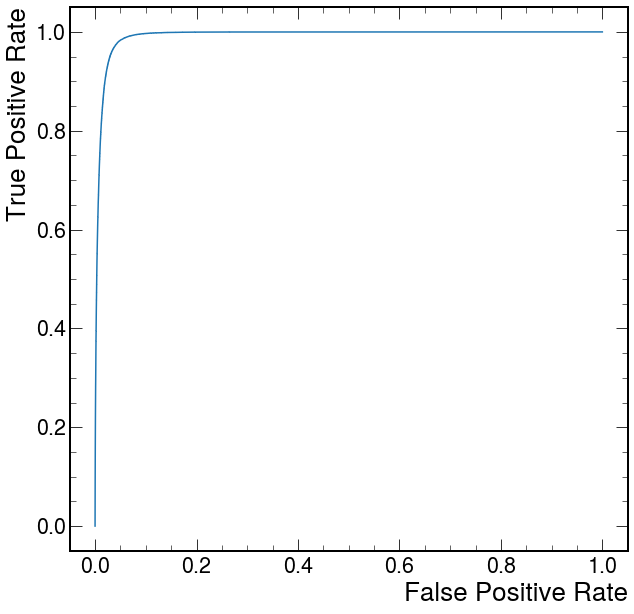

In [72]:
plt.plot(fpr.to('cpu').numpy(),tpr.to('cpu').numpy())
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

In [74]:
roc_auc = ROC_AUC()
roc_auc.attach(default_evaluator, 'roc_auc')
state = default_evaluator.run([[y_preds, y_true]])

In [75]:
print(state)

State:
	iteration: 1
	epoch: 1
	epoch_length: 1
	max_epochs: 1
	output: <class 'list'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'list'>
	seed: <class 'NoneType'>
	times: <class 'dict'>



In [77]:
y_preds_numpy, y_true_numpy = y_preds.detach().numpy(), y_true.detach().numpy()

In [78]:
w1 = weights(y_true_numpy, 10)

In [79]:
fpr1, tpr1, thr1 = roc_curve(y_true_numpy, y_preds_numpy, sample_weight=w1)

In [80]:
roc_auc_score(y_true_numpy, y_preds_numpy)

0.9921537324618968

In [81]:
average_precision_score(y_true_numpy, y_preds_numpy,sample_weight=w1)

0.9897400644061818

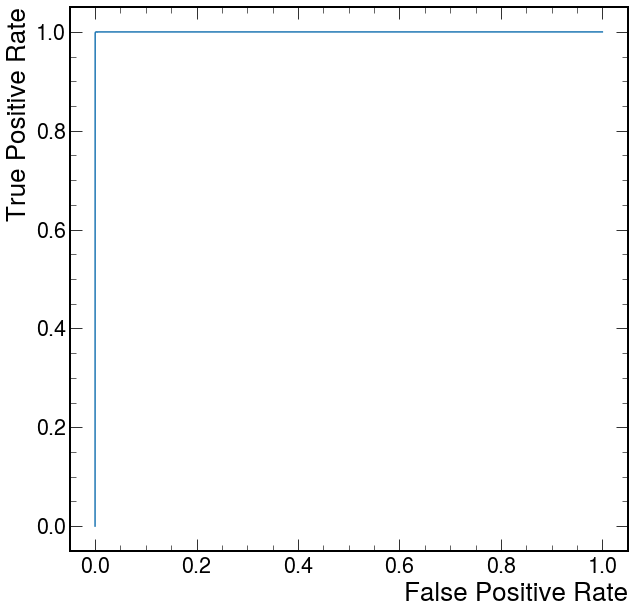

In [122]:
plt.plot(fpr1,tpr1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
    variables = {
    "deltaEta_H_htop" : np.abs(hig.eta - htop.eta),
    "deltaEta_H_ltop" : np.abs(hig.eta - ltop.eta),
    "deltaEta_htop_ltop" : np.abs(htop.eta - ltop.eta),
    "deltaPhi_H_htop" : hig.deltaphi(htop),
    "deltaPhi_H_ltop" : hig.deltaphi(ltop),
    "deltaPhi_htop_ltop" : htop.deltaphi(ltop),
    "Eta_H" : hig.eta,
    "Phi_H" : hig.phi,
    "Pt_H" : hig.pt,
    "Eta_htop" : htop.eta,
    "Phi_htop" : htop.phi,
    "Pt_htop" : htop.pt,
    "Eta_ltop" : ltop.eta,
    "Phi_ltop" : ltop.phi,
    "Pt_ltop" : ltop.pt,
    "Mass_H" : hig.mass,
    "Mass_htop" : htop.mass,
    "deltaEta_h1_h2" : np.abs(jets_higgs[:,0].eta - jets_higgs[:,1].eta),
    "deltaPhi_h1_h2" : jets_higgs[:,0].deltaphi(jets_higgs[:,1]),
    "deltaPt_h1_h2" : np.abs(jets_higgs[:,0].pt - jets_higgs[:,1].pt),
    "Eta_h1" : jets_higgs[:,0].eta,
    "Phi_h1" : jets_higgs[:,0].phi,
    "Pt_h1" : jets_higgs[:,0].pt,
    "deltaEta_ht1_ht2" : np.abs(jets_ht[:,0].eta - jets_ht[:,1].eta),
    "deltaEta_ht1_ht3" : np.abs(jets_ht[:,0].eta - jets_ht[:,2].eta),
    "deltaPhi_ht1_ht2" : jets_ht[:,0].deltaphi(jets_ht[:,1]),
    "deltaPhi_ht1_ht3" : jets_ht[:,0].deltaphi(jets_ht[:,2]),
    "deltaPt_ht1_ht2" : np.abs(jets_ht[:,0].pt - jets_ht[:,1].pt),
    "deltaPt_ht1_ht3" : np.abs(jets_ht[:,0].pt - jets_ht[:,2].pt),
    "Eta_ht1" : jets_ht[:,0].eta,
    "Phi_ht1" : jets_ht[:,0].phi,
    "Pt_ht1" : jets_ht[:,0].pt, 
    "AvEta_ht" : (jets_ht[:,0].eta + jets_ht[:,1].eta + jets_ht[:,2].eta)/3, 
    "deltaEta_h1_ht2" : np.abs(jets_higgs[:,0].eta - jets_ht[:,1].eta),
    "deltaEta_h2_ht3" : np.abs(jets_higgs[:,1].eta - jets_ht[:,2].eta),
    "deltaPt_h1_ht2" : np.abs(jets_higgs[:,0].pt - jets_ht[:,1].pt), 
    "deltaPt_h2_ht3" : np.abs(jets_higgs[:,1].pt - jets_ht[:,2].pt),
    "deltaEta_ht2_ltop" : np.abs(jets_ht[:,1].eta - ltop.eta), 
    "deltaEta_ht3_ltop" : np.abs(jets_ht[:,2].eta - ltop.eta),
    "deltaPt_ht2_ltop" : np.abs(jets_ht[:,1].pt - ltop.pt), 
    "deltaPt_ht3_ltop" : np.abs(jets_ht[:,2].pt - ltop.pt),
    "deltaPhi_ht3_ltop" : jets_ht[:,2].deltaphi(ltop),
    "Mass_ht1_ht2" : (jets_ht[:,0]+jets_ht[:,1]).mass,
    "Mass_ht1_ht3": (jets_ht[:,0]+jets_ht[:,2]).mass,
    "Mass_ht2_ht3" : (jets_ht[:,1]+jets_ht[:,2]).mass }